# Libralies Setup

In [ ]:
%pip install qiskit-machine-learning
%pip install qiskit-aer
%pip install qiskit==1.2.0
%pip install matplotlib
%pip install qiskit_algorithms
%pip install scikit-learn
%pip install AuxFunctions

In [2]:
import numpy as np; import matplotlib.pyplot as plt; import pandas as pd

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler, BaseSamplerV2
from qiskit_algorithms.state_fidelities import ComputeUncompute


# Data Generater and Visualization

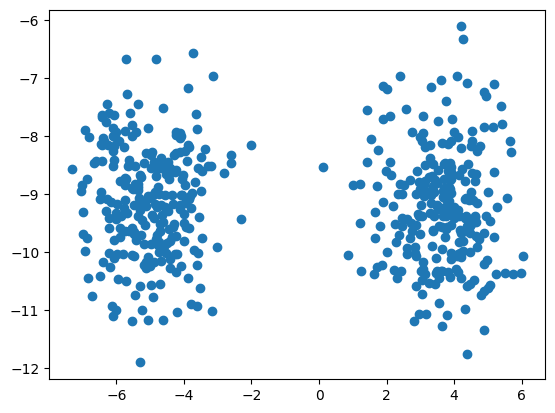

In [3]:

# Step 1: Generate synthetic data
# Create a binary classification dataset
X, y = make_blobs(n_samples=500, n_features=2, centers=2, random_state=41)
plt.scatter(X[:,0],X[:,1])
y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Data Detail Plot

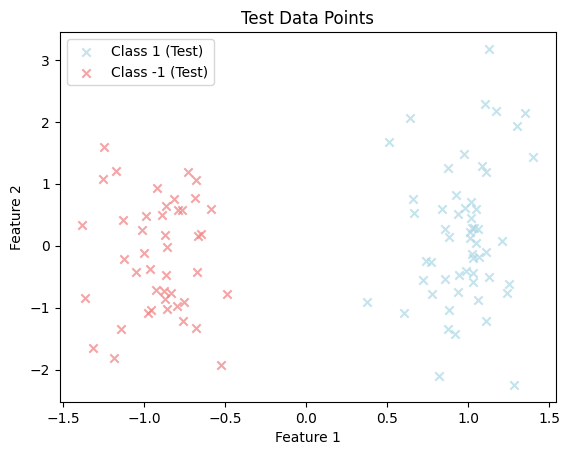

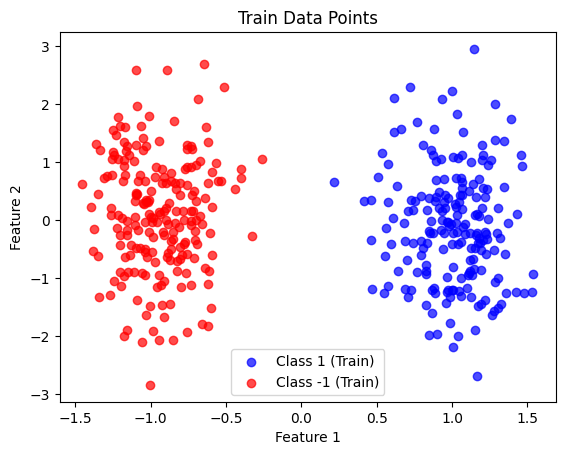

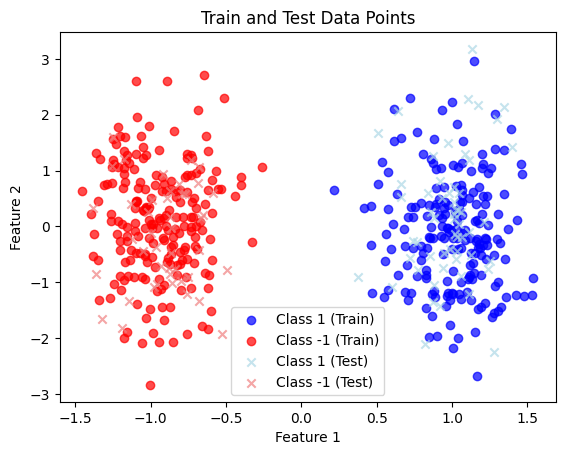

In [4]:
# Plot only Test data (Figure 1)
plt.figure(1)  # Create a new figure
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='lightblue', label='Class 1 (Test)', marker='x', alpha=0.7)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], color='lightcoral', label='Class -1 (Test)', marker='x', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Test Data Points')
plt.legend()

# Plot only Train data (Figure 2)
plt.figure(2)  # Create a new figure
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Class 1 (Train)', alpha=0.7)
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='red', label='Class -1 (Train)', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Train Data Points')
plt.legend()

# Plot both Train and Test data (Figure 3)
plt.figure(3)  # Create a new figure
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Class 1 (Train)', alpha=0.7)
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='red', label='Class -1 (Train)', alpha=0.7)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='lightblue', label='Class 1 (Test)', marker='x', alpha=0.7)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], color='lightcoral', label='Class -1 (Test)', marker='x', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Train and Test Data Points')
plt.legend()

# Show all the plots
plt.show()

# Classical SVM part

In [5]:
clf = SVC(C=1, gamma=0.3877551020408163, kernel="rbf").fit(X_train, y_train)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# Print classification report
print("Training Classification Report:")
print(classification_report(y_train, train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, test_pred))

Training Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       206
           1       1.00      1.00      1.00       194

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Testing Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        56

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



### PCA (if neccessary)

In [6]:
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

### Plot detail after SVM process

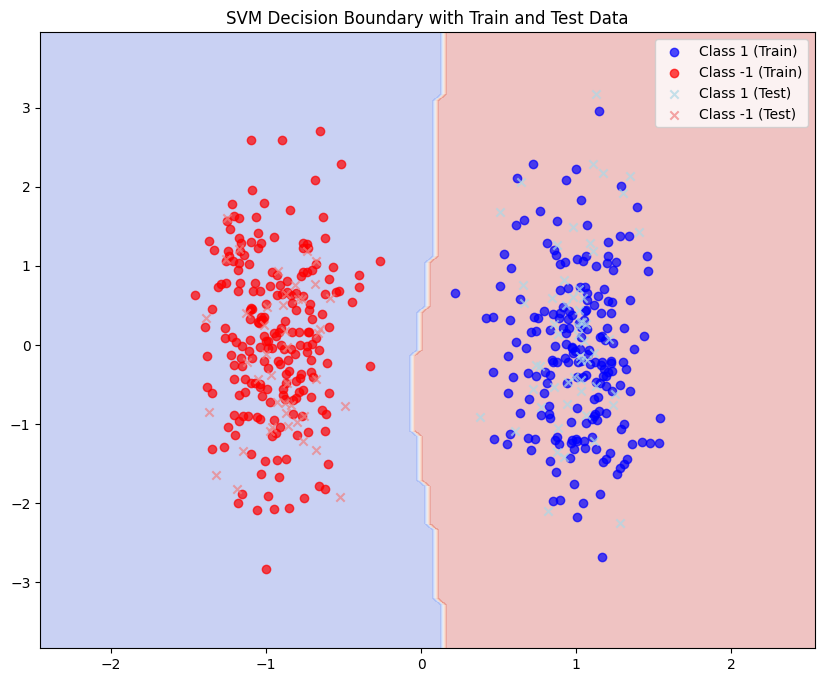

In [7]:
# Generate a meshgrid for plotting decision boundaries
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the class for each point in the meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot training data points
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Class 1 (Train)', alpha=0.7)
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='red', label='Class -1 (Train)', alpha=0.7)

# Plot test data points
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='lightblue', label='Class 1 (Test)', marker='x', alpha=0.7)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], color='lightcoral', label='Class -1 (Test)', marker='x', alpha=0.7)
plt.title('SVM Decision Boundary with Train and Test Data')
plt.legend()
plt.show()

# QSVM part

In [8]:
# Step 2: Define a quantum feature map
FM = ZZFeatureMap(feature_dimension=2, reps=3)


In [9]:

# Step 3: Use QuantumKernel to compute the kernel matrix
fidelity = ComputeUncompute(sampler=Sampler())
quantum_kernel = FidelityQuantumKernel(fidelity=fidelity,feature_map=FM)

# Step 4: Train a QSVM
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train, y_train)

# Step 5: Evaluate the QSVM
accuracy = qsvc.score(X_test, y_test)
accuracy1 = qsvc.score(X_train, y_train)

print(f"Test Accuracy: {accuracy * 100:.2f}% and {accuracy1 * 100:.2f}%")

C:\Users\quang\AppData\Local\Temp\ipykernel_14820\1560738139.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = ComputeUncompute(sampler=Sampler())


Test Accuracy: 72.00% and 70.75%


### Plot detail after QSVM process

In [1]:
# Generate a meshgrid for decision boundary visualization
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

NameError: name 'X_train' is not defined

In [ ]:
# Predict class labels for every point in the meshgrid
Z = qsvc.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
Z = Z.reshape(xx.shape)
# Plot decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot training data points
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Class 1 (Train)', alpha=0.7)
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='red', label='Class -1 (Train)', alpha=0.7)

# Plot test data points
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='lightblue', label='Class 1 (Test)', marker='x', alpha=0.7)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], color='lightcoral', label='Class -1 (Test)', marker='x', alpha=0.7)

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('QSVM Decision Boundary with Train and Test Data')

# Show the legend
plt.legend()

# Display the plot
plt.show()